# Tohoku tsunami inversion
## 10. Inversion using discrete adjoint in P1 basis

We again apply the inversion methodology used in notebook 8 but try to recover a known source.
That is, we run the forward model using the initial surface proposed in __[Saito et al 2011]__, extract timeseries data and then try to invert these data for the free surface with some initial guess.

We also use the mixed continuous-discontinuous discretisation used in notebook 9.

In [1]:
%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import scipy

In [3]:
from thetis import *
from firedrake_adjoint import *

In [4]:
from adapt_utils.case_studies.tohoku.options import TohokuOptions
from adapt_utils.norms import total_variation
from adapt_utils.unsteady.swe.tsunami.conversion import from_latlon
from adapt_utils.misc import box, ellipse, gaussian

Misc plotting routines

In [5]:
def plot_mesh(mesh2d, axes=None):
    if axes is None:
        fig, axes = plt.subplots(figsize=(6, 6))
    triplot(mesh2d, axes=axes);
    axes.axis(False);
    axes.legend(loc='upper left');
    return axes

In [6]:
def plot_field(field, figure=None, axes=None, height=5, **kwargs):
    CG1 = field.ufl_element().degree() == 1 and field.ufl_element().family() == 'Lagrange'
    fs_constructor = FunctionSpace if len(field.function_space().shape) == 0 else VectorFunctionSpace
    out = field if CG1 else interpolate(field, fs_constructor(field.function_space().mesh(), "CG", 1))
    
    if figure is None and axes is None:
        figure, axes = plt.subplots(figsize=(height*1.2, height))
    if axes is None:
        axes = plt.gca()
    figure.colorbar(tricontourf(out, levels=50, axes=axes, cmap='coolwarm', **kwargs), ax=axes);
    axes.axis(False);
    axes.set_title(field.dat.name);
    return axes

In [7]:
def plot_fields(*fields, height=5):
    nfields = len(fields)
    fig, axes = plt.subplots(ncols=nfields, figsize=(height*nfields*1.2, height))
    for i, field in enumerate(fields):
        plot_field(field, fig, axes[i])
    return axes

In [8]:
level = 0
# level = 1
# level = 2

op = TohokuOptions(level=level)
gauges = list(op.gauges.keys())
for gauge in gauges:
    try:
        op.default_mesh.coordinates.at(op.gauges[gauge]['coords'])
    except PointNotInDomainError:
        op.gauges.pop(gauge)  # Some gauges aren't within the domain

mesh = op.default_mesh
P1 = FunctionSpace(mesh, "CG", 1)

boundary_conditions = {
    100: {'un': Constant(0.0), 'elev': 0},
    200: {'un': Constant(0.0)},
    300: {'un': Constant(0.0)},
}

### Forward model

As before, consider the nonlinear shallow water equations:

$$
    \frac{\partial\mathbf u}{\partial t}
    +\mathbf u\cdot\nabla\mathbf u
    +g\nabla\eta
    +f\widehat{\mathbf z}\times\mathbf u
    =\boldsymbol0,\qquad
    \frac{\partial\eta}{\partial t}
    +\nabla\cdot(H\mathbf u)=0,\qquad
    \text{in}\quad(0,T]\times\Omega,
$$

equipped with boundary conditions

$$
    \mathbf u\cdot\widehat{\mathbf n}|_{\Gamma_{\mathrm{freeslip}}}\equiv0,\qquad
    \eta|_{\Gamma_D}\equiv0.
$$

Define fields for forward model, e.g. bathymetry from GEBCO.

In [9]:
def get_fields(fs):
    """
    Define fields associated with the physical model, as well as the gravitational acceleration constant.
      
    :arg fs: the mixed function space used to solve the forward problem. The bathymetry and the Coriolis
        parameter are taken to live in the associated elevation space.
    """
    b = Function(fs, name="Bathymetry (from GEBCO)").assign(op.set_bathymetry(fs))
    f = Function(fs, name="Coriolis parameter").assign(op.set_coriolis(fs))
    g = Constant(op.g)  # Gravitational acceleration
    gamma = Constant(0.025)  # Manning drag coefficient
    return b, f, g, gamma

In [10]:
def solve_forward(initial_condition, artificial=False, rotational=False, store_timeseries=False, ext=''):
    """
    Solve the shallow water equations for some `initial_condition`.
    """
    print("FORWARD SOLVE")
    
    # --- Setup function spaces
    
    P0 = FunctionSpace(mesh, "DG", 0)
    P1 = FunctionSpace(mesh, "CG", 1)
    
    # -- Setup fields
    
    b, f, g, gamma = get_fields(P1)
    
    # --- Setup PDE
    
    solver_obj = solver2d.FlowSolver2d(mesh, b)
    options = solver_obj.options
    options.timestep = op.dt
    options.simulation_end_time = op.end_time
    options.simulation_export_time = 48*op.dt
    options.output_directory = 'outputs/inversion'
    options.timestepper_type = 'CrankNicolson'
    options.element_family = 'dg-cg'
    options.norm_smoother = Constant(0.01)
    options.use_lax_friedrichs_velocity = True
    options.lax_friedrichs_velocity_scaling_factor = Constant(1.0)
    options.horizontal_viscosity = None
    if rotational:
        options.coriolis_frequency = f
    options.manning_drag_coefficient = gamma
    solver_obj.bnd_functions['shallow_water'] = boundary_conditions
    solver_obj.create_function_spaces()
    
    # --- Setup initial condition / control
        
    # Time integration parameters
    options.timestepper_options.implicitness_theta = 0.5  # Default for Crank-Nicolson
    options.timestepper_options.use_semi_implicit_linearization = True  # Needed due to Manning drag term
    options.timestepper_options.solver_parameters['snes_converged_reason'] = None
    options.timestepper_options.solver_parameters['ksp_converged_reason'] = None
    
    # Assign initial conditions manually to avoid splitting annotation
    if not solver_obj._initialized:
        solver_obj.initialize()
#     solver_obj.fields.solution_2d.assign(initial_condition)
    solver_obj.fields.solution_2d.project(initial_condition)
    solver_obj.timestepper.initialize(solver_obj.fields.solution_2d)
    
    # --- Setup QoI
    
    radius = 20.0e+03*pow(0.5, level)  # The finer the mesh, the more precise the indicator region
    for gauge in op.gauges:
        op.gauges[gauge]['indicator'] = interpolate(ellipse([op.gauges[gauge]["coords"] + (radius,), ], mesh), P0)
        if artificial:
            op.gauges[gauge]['data'] = []
        elif store_timeseries:
            op.gauges[gauge]['timeseries'+ext] = []
            op.gauges[gauge]['diff'+ext] = []
            op.gauges[gauge]['timeseries_smooth'+ext] = []
            op.gauges[gauge]['diff_smooth'+ext] = []
            op.gauges[gauge]['init'+ext] = None
            op.gauges[gauge]['area'] = assemble(op.gauges[gauge]['indicator']*dx, annotate=False)
    times = []
    op.J = 0
    eta_obs = Constant(0.0)
    weight = Constant(1.0)
    dtc = Constant(op.dt)
    shift = Constant(0.0)
    
    def update_forcings(t):
        iteration = solver_obj.iteration
        times.append(t)
        weight.assign(0.5 if np.allclose(t, 0.0) or np.allclose(t, op.end_time) else 1.0)
        eta = solver_obj.fields.elev_2d
        for gauge in op.gauges:
            
            # Interpolate observations
            if artificial:
                obs = eta.at(op.gauges[gauge]["coords"])
                op.gauges[gauge]['data'].append(float(obs))
            else:
                obs = op.gauges[gauge]['data'][iteration] - op.gauges[gauge]['data'][0]
                eta_obs.assign(obs)
            
                if store_timeseries:

                    # Point evaluation at gauges
                    eta_discrete = eta.at(op.gauges[gauge]["coords"])
                    if np.allclose(t, 0.0):
                        op.gauges[gauge]['init'+ext] = eta_discrete
                    op.gauges[gauge]['timeseries'+ext].append(float(eta_discrete - op.gauges[gauge]['init'+ext]))

                    # Discrete form of error
                    diff = 0.5*(eta_discrete - eta_obs.dat.data[0])**2
                    op.gauges[gauge]['diff'+ext].append(diff)

                # Continuous form of error
                I = op.gauges[gauge]['indicator']
                shift.assign(op.gauges[gauge]['init'+ext])
                eta_shift = eta - shift
                diff = 0.5*I*(eta_shift - eta_obs)**2
                op.J += assemble(weight*dtc*diff*dx)
                if store_timeseries:
                    A = op.gauges[gauge]['area']
                    op.gauges[gauge]['diff_smooth'+ext].append(assemble(diff*dx, annotate=False)/A)
                    op.gauges[gauge]['timeseries_smooth'+ext].append(assemble(I*eta_shift*dx, annotate=False)/A)
    
    update_forcings(0.0)
    solver_obj.iterate(update_forcings=update_forcings)
    if artificial:
        op.J = np.nan
    else:
        print("    Quantity of interest = {:.8e}".format(op.J))
    return op.J, solver_obj.fields.solution_2d

We use the initial free surface computed using inversion in __[Saito et al. 2011]__ as an initial condition for the artificial run which we seek to invert for.

In [11]:
with stop_annotating():
    mixed_space = get_functionspace(mesh, "DG", 1, vector=True)*get_functionspace(mesh, "CG", 2)
    ic = Function(mixed_space)
    ic_uv, ic_elev = ic.split()
    ic_uv.dat.name = "Initial velocity"
    ic_elev.dat.name = "Initial surface"
    ic_elev.interpolate(op.set_initial_surface(P1));
    solve_forward(ic, artificial=True)

FORWARD SOLVE


Using default SIPG parameters
dt = 5.0
Using time integrator: CrankNicolson
    0     0 T=      0.00 eta norm: 758974.7447 u norm:     0.0000  0.00
    1    48 T=    240.00 eta norm: 547017.5683 u norm: 29447.9486  6.03
    2    96 T=    480.00 eta norm: 459151.3721 u norm: 40198.7264  5.17
    3   144 T=    720.00 eta norm: 514043.2797 u norm: 42436.8160  5.12
    4   192 T=    960.00 eta norm: 538174.0954 u norm: 49257.2087  5.19
    5   240 T=   1200.00 eta norm: 533615.1905 u norm: 62826.2304  5.28
    6   288 T=   1440.00 eta norm: 529076.3761 u norm: 78209.2496  5.28


As before, we filter the initial condition using a kernel function which zeroes out the velocity and the initial free surface except for a rectangular region aligned with the fault centred at the earthquake epicentre, of widths 280km and 140km parallel and perpendicular to the fault, resp.

In [12]:
xy = tuple(from_latlon(38.0, 143.2, force_zone_number=54))
radii = (140e+03, 280e+03)
angle = pi/10
loc = [xy + radii, ]

kernel = Function(mixed_space)
kernel_u, kernel_eta = kernel.split()
kernel_eta.interpolate(box(loc, mesh, rotation=angle));

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb9fc8ce630>,
      dtype=object)

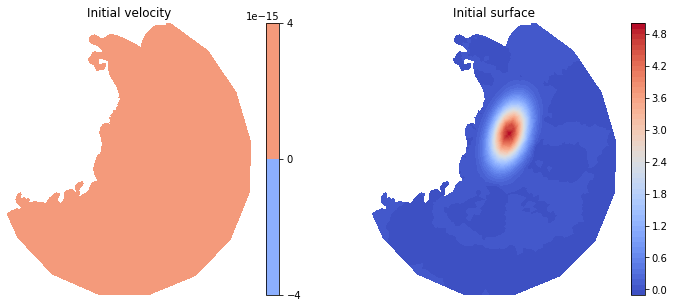

In [13]:
initial_surface = Function(P1, name="Initial surface")
initial_surface.interpolate(5.0*gaussian([(0.7e+06, 4.2e+06, 72e+03, 144e+03), ], mesh, rotation=pi/12))
ic.project(kernel*initial_surface);
plot_fields(*ic.split())

In [14]:
J, q = solve_forward(ic, store_timeseries=True)
u, eta = q.split()
u.dat.name = "Velocity (initial guess control)"
eta.dat.name = "Elevation (initial guess control)"

FORWARD SOLVE


Using default SIPG parameters
dt = 5.0
Using time integrator: CrankNicolson
    0     0 T=      0.00 eta norm: 627744.7632 u norm:     0.0000  0.00
    1    48 T=    240.00 eta norm: 513560.4284 u norm: 19100.6239  8.05
    2    96 T=    480.00 eta norm: 416707.7405 u norm: 28491.2416  7.40
    3   144 T=    720.00 eta norm: 408074.0221 u norm: 33701.3603  7.87
    4   192 T=    960.00 eta norm: 419528.5539 u norm: 39939.6582  7.72
    5   240 T=   1200.00 eta norm: 427588.2649 u norm: 47600.6991  7.58
    6   288 T=   1440.00 eta norm: 433640.4319 u norm: 55012.1405  8.33


    Quantity of interest = 1.25474459e+13


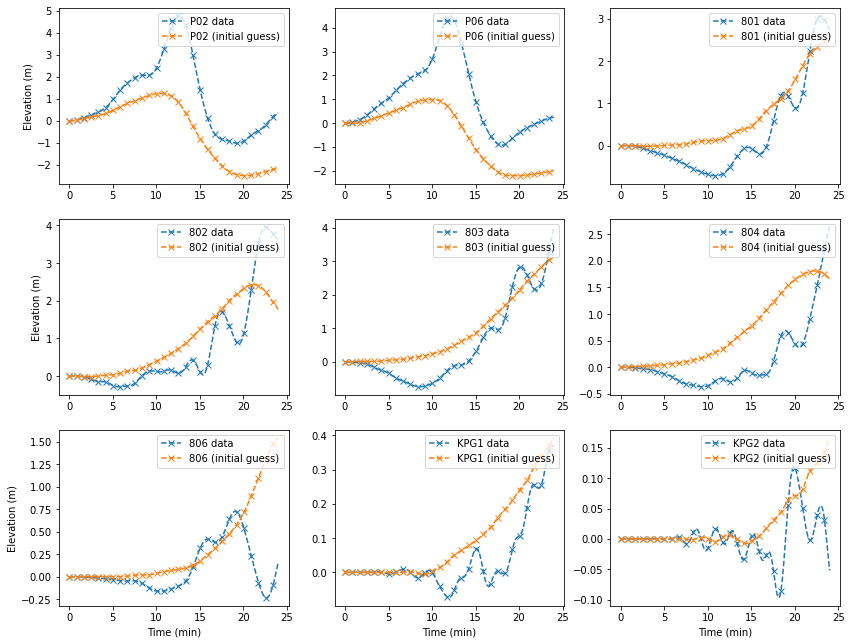

In [15]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(14, 11))

times = np.linspace(0, op.end_time, int(op.end_time/op.dt))
for i, gauge in enumerate(op.gauges):
    ax = axes[i//3, i%3]
    toplot = np.array(op.gauges[gauge]['data'][:-1]) - op.gauges[gauge]['data'][0]
    ax.plot(times/60, toplot, '--x', label=gauge + ' data', markevery=10)
    ax.plot(times/60, op.gauges[gauge]['timeseries'][:-1], '--x', label=gauge + ' (initial guess)', markevery=10)
    ax.legend(loc='upper right')
    if i//3 == 2:
        ax.set_xlabel('Time (min)')
    if i%3 == 0:
        ax.set_ylabel('Elevation (m)')

## Inversion in the P1 basis

In [16]:
opt_kwargs = {
    'maxiter': 20,
    'gtol': 1.0,
}

def eval_cb_post(j, m):
    print("functional value {:.8e}".format(j))

def derivative_cb_post(j, dj, m):
    print("functional value {:.8e}  norm of gradient {:.8e}".format(j, norm(dj)))

Jhat = ReducedFunctional(J, Control(initial_surface), eval_cb_post=eval_cb_post, derivative_cb_post=derivative_cb_post)

In [17]:
ic_opt = minimize(Jhat, method='BFGS', options=opt_kwargs)

functional value 1.25474461e+13
functional value 1.25474461e+13  norm of gradient 2.37695208e+16
functional value 1.16724300e+13
functional value 1.16724300e+13  norm of gradient 2.04494439e+16
functional value 1.04663946e+13
functional value 1.04663946e+13  norm of gradient 2.14538201e+16
functional value 9.81759277e+12
functional value 9.81759277e+12  norm of gradient 2.32157887e+16
functional value 9.21567732e+12
functional value 9.21567732e+12  norm of gradient 2.28590508e+16
functional value 8.77130929e+12
functional value 8.77130929e+12  norm of gradient 2.28123818e+16
functional value 8.29060261e+12
functional value 8.29060261e+12  norm of gradient 2.24396259e+16
functional value 8.19174970e+12
functional value 8.19174970e+12  norm of gradient 2.30177634e+16
functional value 8.04477236e+12
functional value 8.04477236e+12  norm of gradient 2.27482823e+16
functional value 7.87891431e+12
functional value 7.87891431e+12  norm of gradient 2.29783378e+16
functional value 7.71023393e+1

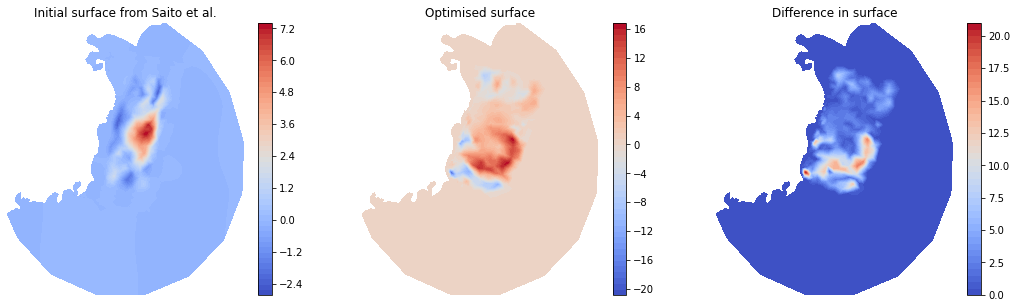

In [18]:
ic_opt.dat.name = "Optimised surface"
saito = Function(P1, name="Initial surface from Saito et al.").assign(op.set_initial_surface(P1))

surface_diff = Function(P1, name="Difference in surface")
surface_diff.interpolate(abs(saito - ic_opt))

plot_fields(saito, ic_opt, surface_diff);

In [19]:
ic.project(kernel*ic_opt);

In [20]:
J, q_opt = solve_forward(ic, store_timeseries=True, ext='_opt')

FORWARD SOLVE


Using default SIPG parameters
dt = 5.0
Using time integrator: CrankNicolson
    0     0 T=      0.00 eta norm: 2300049.4035 u norm:     0.0000  0.00
    1    48 T=    240.00 eta norm: 1714810.2854 u norm: 120093.9979  8.90
    2    96 T=    480.00 eta norm: 1483346.5986 u norm: 157372.1985  8.40
    3   144 T=    720.00 eta norm: 1454103.4111 u norm: 182440.4033  8.51
    4   192 T=    960.00 eta norm: 1566962.3787 u norm: 204409.3900  9.79
    5   240 T=   1200.00 eta norm: 1627552.7759 u norm: 242640.4741  9.16
    6   288 T=   1440.00 eta norm: 1609571.8690 u norm: 291502.4436  9.41


    Quantity of interest = 8.29035878e+12


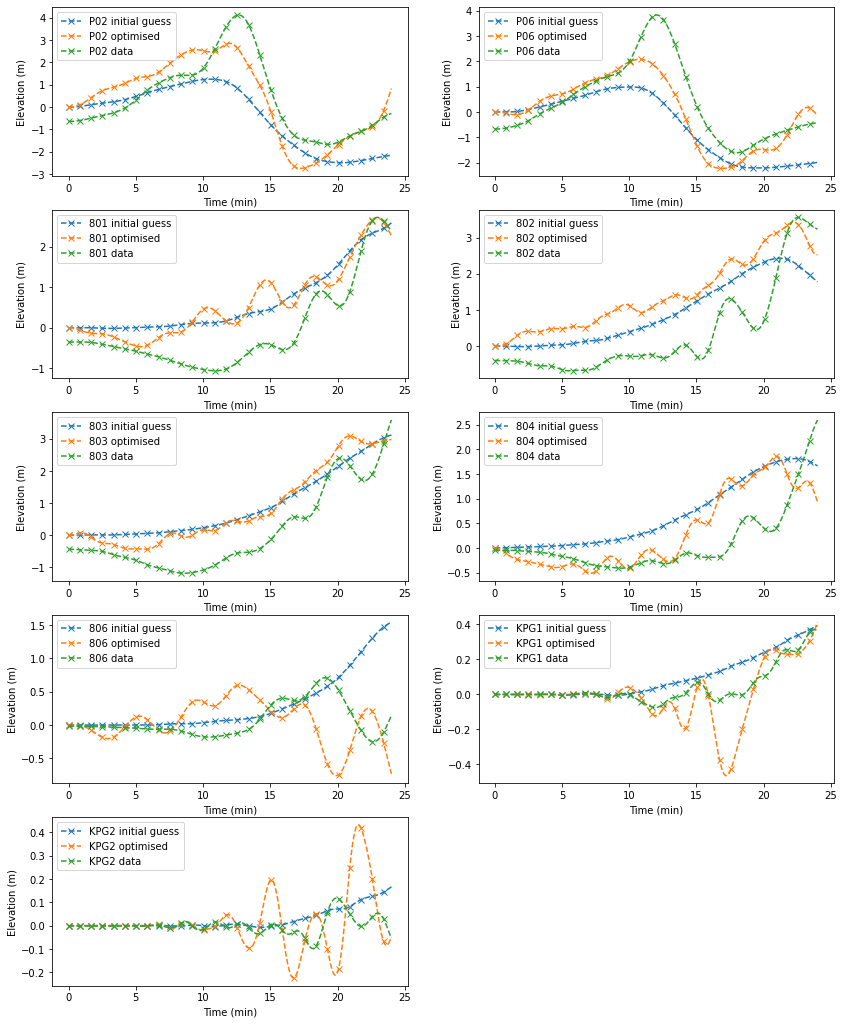

In [21]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(14, 2*len(op.gauges)))

times = np.linspace(0, op.end_time, int(op.end_time/op.dt))
for i, gauge in enumerate(op.gauges):
    ax = axes[i//2, i%2]
#     ax.plot(times/60, op.gauges[gauge]['timeseries_smooth'], '--x', label=gauge + ' initial guess', markevery=10)
#     ax.plot(times/60, op.gauges[gauge]['timeseries_smooth_opt'], '--x', label=gauge + ' optimised', markevery=10)
    ax.plot(times/60, op.gauges[gauge]['timeseries'][:-1], '--x', label=gauge + ' initial guess', markevery=10)
    ax.plot(times/60, op.gauges[gauge]['timeseries_opt'][:-1], '--x', label=gauge + ' optimised', markevery=10)
    ax.plot(times/60, op.gauges[gauge]['data'][:-1], '--x', label=gauge + ' data', markevery=10)
    ax.legend(loc='upper left')
    ax.set_xlabel('Time (min)')
    ax.set_ylabel('Elevation (m)')
axes[4, 1].axis('off');